In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join

from astropy.io import ascii
import glob, re

% matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=18               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12


In [3]:
fname_spc = '../data/spc_giants.csv'
fname_guy = '../data/smear_Dnu.csv'

In [4]:
spc_data = Table.read(fname_spc,format='ascii')

guy_data = Table.read(fname_guy,format='ascii')
guy_data.rename_column('Star_ID','Object')
print guy_data.keys()

['Object', 'Dnu', 'Dnu_err', 'Numax', 'Numax_err', 'eps', 'eps_err']


In [5]:
guy_data.sort('Object')
spc_data.sort('Object')

In [8]:
# spc_data

In [9]:
numax_sun = 3160.
numax_sun_err = 10.

Teff_sun = 5777.
logg_sun = 4.43812

In [10]:
mapping = np.array([np.where(guy_data['Object'][:]==obj)[0][0] for obj in spc_data['Object'] if (obj in guy_data['Object'])])
missing = np.array([obj not in guy_data['Object'] for obj in spc_data['Object']])

In [11]:
# new_table = join(guy_data[mapping],spc_data[~missing])
new_table = join(guy_data,spc_data)

In [12]:
# spc_data['Object'].pprint(max_lines=70)

In [13]:
# new_table.keys()

In [14]:
g = ((new_table['Teff']/Teff_sun)**0.5) * (new_table['Numax']/numax_sun)
log_g = np.log10(g)+logg_sun

In [16]:
# new_table['logg']

## Now we do it with Monte Carlo

In [17]:
teffs = new_table['Teff'] 
numaxes = new_table['Numax']
numax_errs = new_table['Numax_err']
N = len(teffs)

# data = dict(teff=teffs,mu_numax=numaxes,sig_numax=numax_errs,numax_sun=numax_sun,teff_sun=Teff_sun,N=N)

In [18]:
log_g = []
log_g_err = []

for j in range(N):
    thisnumax = numax_errs[j]*np.random.randn(10000)+numaxes[j]
    thislogg = np.log10((teffs[j]/Teff_sun)**0.5 * (thisnumax/numax_sun))
    log_g.append(np.mean(thislogg))
    log_g_err.append(np.std(thislogg))
    
log_g = np.array(log_g)+logg_sun
log_g_err = np.array(log_g_err)

(array([1., 8., 3., 7., 3., 5., 2., 1., 2., 2.]),
 array([ 25.40266557,  36.62603924,  47.84941291,  59.07278658,
         70.29616026,  81.51953393,  92.7429076 , 103.96628127,
        115.18965494, 126.41302861, 137.63640228]),
 <a list of 10 Patch objects>)

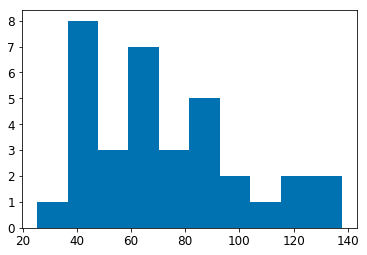

In [19]:
plt.hist(numaxes/numax_errs)

In [20]:
new_table['Object'].pprint(max_lines=40)

  Object  
----------
BD+36_3564
BD+39_3577
BD+43_3171
BD+43_3213
BD+48_2955
 HD_174020
 HD_174829
 HD_175740
 HD_175740
 HD_175740
 HD_175740
 HD_175740
 HD_175884
 HD_178797
 HD_178910
 HD_179396
 HD_180312
 HD_180312
 HD_180475
 HD_180658
 HD_180682
 HD_181022
 HD_181069
 HD_181097
 HD_181597
 HD_181778
 HD_181880
 HD_182531
 HD_182692
 HD_182694
 HD_183124
 HD_185286
 HD_188537
 HD_226754


In [22]:
output = Table({'Object':new_table['Object'],
                'numax':numaxes,
                'numax_err':numax_errs,
                'log_g':log_g,
                'log_g_err':log_g_err})
output.write('pope_asteroseismology.csv',format='csv',overwrite=True)

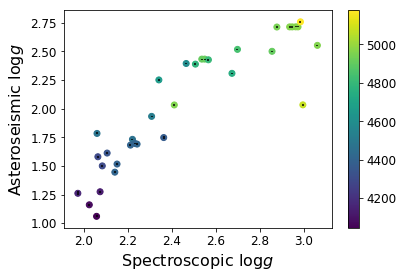

In [23]:
plt.scatter(new_table['logg'],log_g,c=new_table['Teff'])
plt.errorbar(new_table['logg'],log_g,yerr=log_g_err,linestyle='',color='k')
plt.colorbar()
plt.xlabel(r'Spectroscopic $\log{g}$')
plt.ylabel(r'Asteroseismic $\log{g}$')
plt.savefig('numax_correlation.png')

In [24]:
# output